In [ ]:
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

from google.colab import files
uploaded = files.upload()

Saving english-corpus.txt to english-corpus.txt
Saving urdu-corpus.txt to urdu-corpus.txt


In [ ]:
def rev_sentence(sentence):
    words = sentence.split(' ')
    reverse_sentence = ' '.join(reversed(words))
    return reverse_sentence

file1 = open("english-corpus.txt", "r+")
file_content = file1.readlines()
file1.close()

file2 = open("urdu-corpus.txt", "r+", encoding="utf8")
file_content2 = file2.readlines()
file2.close()

text_pairs = []

for i in range(len(file_content)):
    eng_text = file_content[i].strip("\n")
    urdu = file_content2[i].strip("\n")
    urdu_text = "[start] " + rev_sentence(urdu) + " [end]"
    combine = (eng_text,urdu_text)
    text_pairs.append(combine)

eng_tokens, urdu_tokens = set(), set()
eng_maxlen, urdu_maxlen = 0, 0
for eng, urdu in text_pairs:
    eng_tok, urdu_tok = eng.split(), urdu.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    urdu_maxlen = max(urdu_maxlen, len(urdu_tok))
    eng_tokens.update(eng_tok)
    urdu_tokens.update(urdu_tok)
print(f"English tokens: {len(eng_tokens)}")
print(f"Urdu tokens: {len(urdu_tokens)}")
print(f"Max English len: {eng_maxlen}")
print(f"Max Urdu len: {eng_maxlen}")
print(f"{len(text_pairs)} total pairs")

English tokens: 5766
Urdu tokens: 5988
Max English len: 16
Max Urdu len: 16
24525 total pairs


In [ ]:
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

vocab_size_en = 5500
vocab_size_ur = 5500
seq_length = 20

eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
urdu_vectorizer = TextVectorization(
    max_tokens=vocab_size_ur,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_urdu_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
urdu_vectorizer.adapt(train_urdu_texts)

data = {
    "train": train_pairs,
    "val":   val_pairs,
    "test":  test_pairs,
    "engvec_config":  eng_vectorizer.get_config(),
    "engvec_weights": eng_vectorizer.get_weights(),
    "urduvec_config":  urdu_vectorizer.get_config(),
    "urduvec_weights": urdu_vectorizer.get_weights(),
}

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
urdu_vectorizer = TextVectorization.from_config(data["urduvec_config"])
urdu_vectorizer.set_weights(data["urduvec_weights"])

def format_dataset(eng, urdu):
    eng = eng_vectorizer(eng)
    urdu = urdu_vectorizer(urdu)
    source = {"encoder_inputs": eng,
              "decoder_inputs": urdu[:, :-1]}
    target = urdu[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    eng_texts, urdu_texts = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(urdu_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

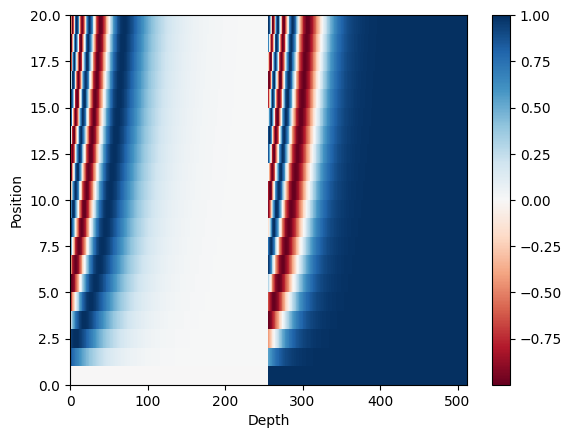

In [ ]:
def pos_enc_matrix(L, d, n=10000):
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)
    i = np.arange(d2).reshape(1, -1)
    denom = np.power(n, -i/d2)
    args = k * denom
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):

        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )

        matrix = pos_enc_matrix(sequence_length, embed_dim)

        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

matrix = pos_enc_matrix(seq_length, 512)
plt.pcolormesh(np.hstack([matrix[:, ::2], matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

# test the dataset
for inputs, targets in train_ds.take(1):
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])

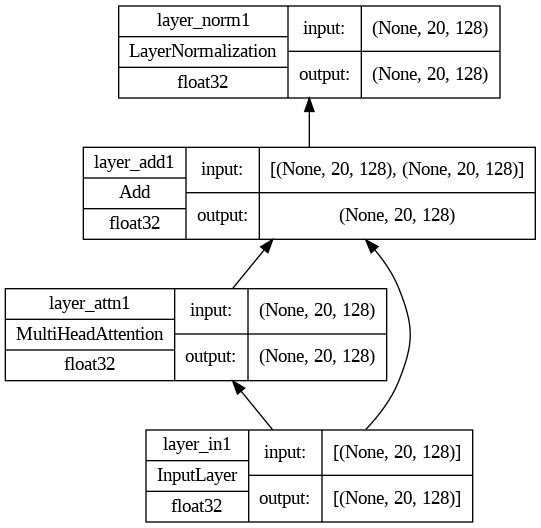

In [ ]:
def self_attention(input_shape, prefix="layer", mask=False, **kwargs):
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

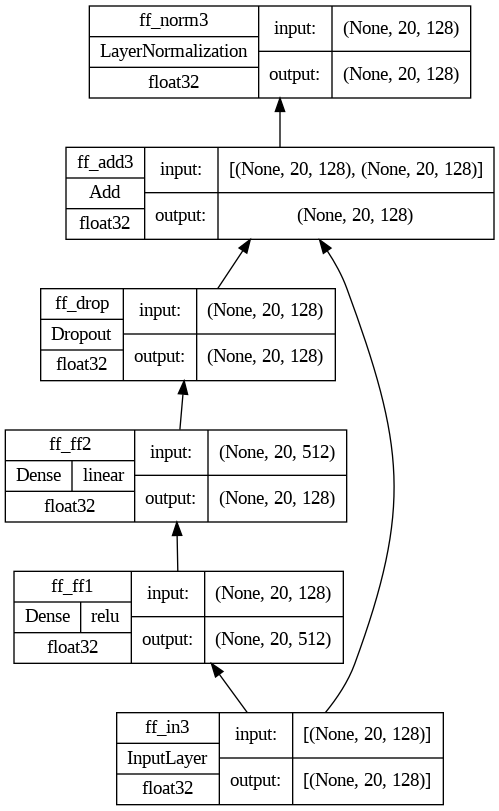

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.15, prefix="ff"):
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

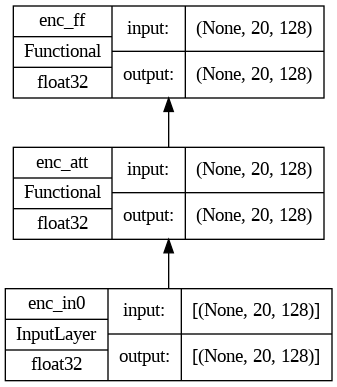

In [ ]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.15, prefix="enc", **kwargs):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model

num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

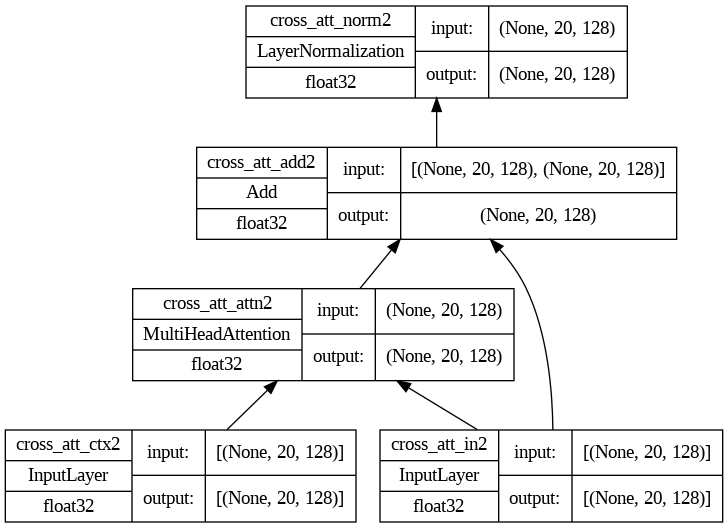

In [ ]:
def cross_attention(input_shape, context_shape, prefix="cross_att", **kwargs):
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

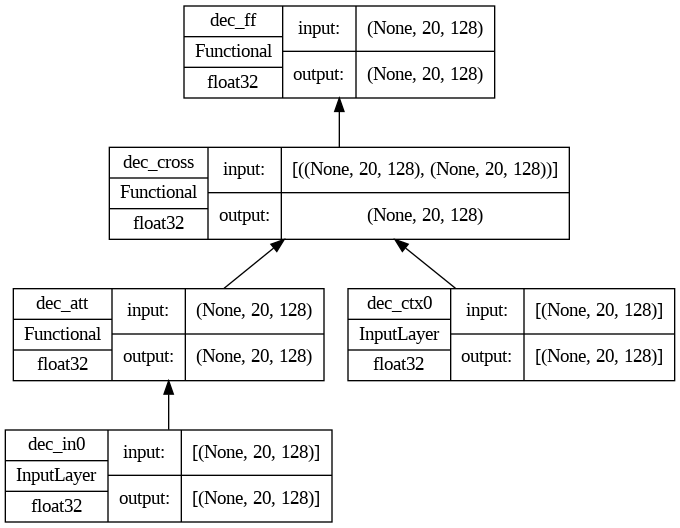

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.15, prefix="dec", **kwargs):
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

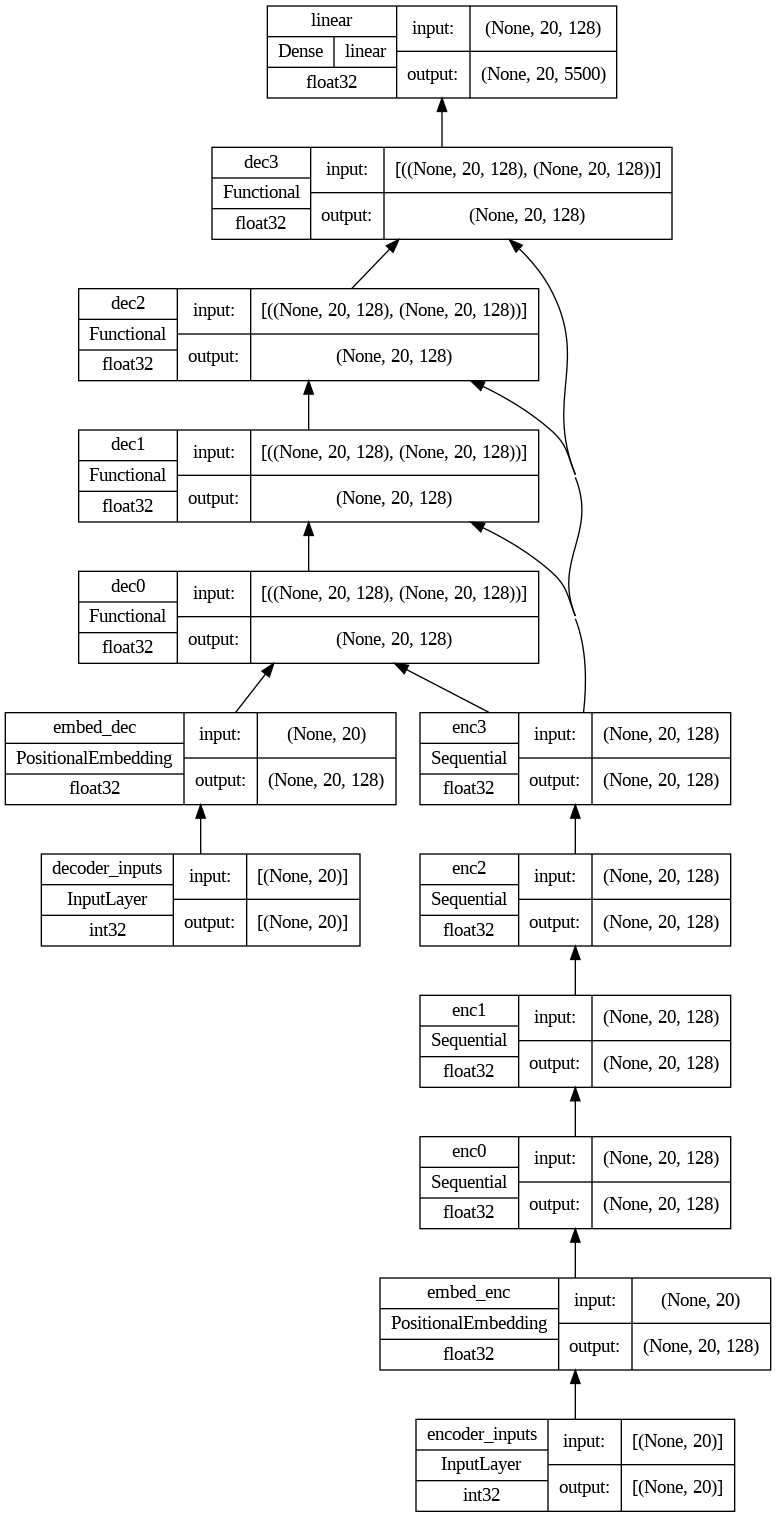

In [ ]:
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.15, name="transformer"):
    embed_shape = (seq_len, key_dim)
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


vocab_size_en = 5500
vocab_size_ur = 5500
seq_length = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.15
model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim,
                    vocab_size_en, vocab_size_ur, dropout)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

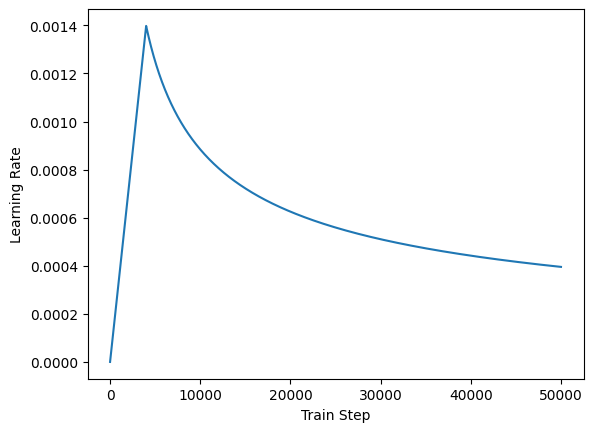

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
vocab_size_en = 5500
vocab_size_ur = 5500
seq_length = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.15
model = transformer(num_layers, num_heads, seq_length, key_dim, ff_dim,
                    vocab_size_en, vocab_size_ur, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     704000      ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

In [ ]:
epochs = 5
model.load_weights("urdu-transformer.h5")
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

model.save("urdu-transformer.h5")

Epoch 1/5
269/269 [==============================] - 25s 91ms/step - loss: 0.4746 - masked_accuracy: 0.8722 - val_loss: 2.6295 - val_masked_accuracy: 0.6295
Epoch 2/5
269/269 [==============================] - 20s 75ms/step - loss: 0.4078 - masked_accuracy: 0.8869 - val_loss: 2.6821 - val_masked_accuracy: 0.6231
Epoch 3/5
269/269 [==============================] - 21s 79ms/step - loss: 0.3595 - masked_accuracy: 0.9001 - val_loss: 2.7311 - val_masked_accuracy: 0.6223
Epoch 4/5
269/269 [==============================] - 20s 76ms/step - loss: 0.3161 - masked_accuracy: 0.9103 - val_loss: 2.7758 - val_masked_accuracy: 0.6255
Epoch 5/5
269/269 [==============================] - 21s 79ms/step - loss: 0.2788 - masked_accuracy: 0.9201 - val_loss: 2.8316 - val_masked_accuracy: 0.6293


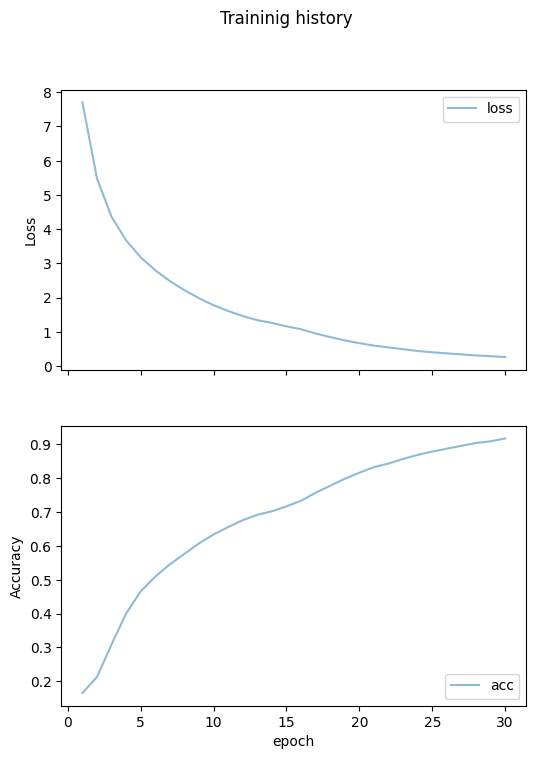

In [ ]:
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

In [ ]:
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("urdu-transformer.h5")

def translate(sentence):
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(urdu_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    for i in range(seq_length):
        vector = urdu_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_length+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_length)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_length, vocab_size_ur)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

In [ ]:
test_count = 20
for n in range(test_count):
    english_sentence, urdu_sentence = random.choice(test_pairs)
    translated = ' '.join(translate(english_sentence))
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {rev_sentence(urdu_sentence)}")
    print(f"-> {rev_sentence(translated)}")
    print()

Test 0:
write me
== [end] مجھے لکھنا [start]
-> [end] مجھے لکھیں [start]

Test 1:
i wont forget it
== [end] میں اسے نہیں بھولوں گا [start]
-> [end] میں یہ نہیں بھولوں گا۔ [start]

Test 2:
the boy is kind
== [end] لڑکا مہربان ہے [start]
-> [end] لڑکا پیاری ہے۔ [start]

Test 3:
i am lonely
== [end] میں تنہا ہوں [start]
-> [end] میں تنہا ہوں [start]

Test 4:
zain can dance well
== [end] زین اچھا ناچ سکتا ہے۔ [start]
-> [end] زین رقص کر سکتا ہے [start]

Test 5:
you cant marry tom
== [end] تم ٹام سے شادی نہیں کر سکتے [start]
-> [end] آپ ٹام سے شادی نہیں کر سکتے [start]

Test 6:
you can study here
== [end] آپ یہاں پڑھ سکتے ہیں۔ [start]
-> [end] آپ یہاں پڑھ کر سکتے ہیں [start]

Test 7:
i am telling a story
== [end] میں ایک کہانی سنا رہا ہوں۔ [start]
-> [end] میں ایک کہانی بجا رہا ہوں [start]

Test 8:
were humming
== [end] گنگنا رہے تھے [start]
-> [end] گنگنا رہے تھے [start]

Test 9:
i couldnt get it
== [end] میں اسے حاصل نہیں کر سکا [start]
-> [end] میں اسے حاصل کر نہیں سکا [start]

Test 10:


In [ ]:
my_text = "i want to go home"
translated = ' '.join(translate(my_text))
print(f"{my_text}")
print(f"-> {rev_sentence(translated)}")

i want to go home
-> [end] میں گھر جانا چاہتا ہوں [start]
